## Prob 2

#### Preprocessing the data

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Seed for random state
seed = 42
torch.manual_seed(seed)

# Load housing dataset
housing_dataset = pd.read_csv('./../data/Housing.csv', delimiter=',')

# Prepare the dataset.

# List of variable to map to numerical values.
varlist = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
housing_dataset[varlist] = housing_dataset[varlist].apply(binary_map)

# preview the dataset
housing_dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [2]:
# Extract the desired features
filter = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']

housing_filtered = housing_dataset[filter]
housing_filtered.head()

,area,bedrooms,bathrooms,stories,parking,price
0,7420,4,2,3,2,13300000
1,8960,4,4,4,3,12250000
2,9960,3,2,2,2,12250000
3,7500,4,2,2,3,12215000
4,7420,4,1,2,2,11410000


In [3]:
# array of data
data = housing_filtered.values
data.shape

(545, 6)

In [4]:
# Generate random indices for training and validation data.
n_samples = data.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# Transform data to a tensor
torch_data = torch.tensor(data, dtype=torch.double)

# Filter the train and val subsets from the dataset
torch_train_data = torch_data[train_indices]
torch_val_data = torch_data[val_indices]

In [5]:
# Convert train and val tensors to numpy arrays
np_train_data = torch_train_data.numpy()
np_val_data = torch_val_data.numpy()
print(np_train_data.shape)
print(np_val_data.shape)

# Normalize the train and val subsets using the MinMaxScaler
sc_nn =  MinMaxScaler()
t_n_train = torch.from_numpy(sc_nn.fit_transform(np_train_data))
t_n_val = torch.from_numpy(sc_nn.transform(np_val_data))

(436, 6)
(109, 6)


In [6]:
# Filter features and targets for training and validation.
t_un_train = t_n_train[:, :-1]
t_cn_train = t_n_train[:, -1].unsqueeze(1)

t_un_val = t_n_val[:, :-1]
t_cn_val = t_n_val[:, -1].unsqueeze(1)

t_un_train.shape, t_cn_train.shape, t_un_val.shape, t_cn_val.shape

(torch.Size([436, 5]),
 torch.Size([436, 1]),
 torch.Size([109, 5]),
 torch.Size([109, 1]))

#### Create and train the Model

In [7]:
def model(t_u, w):
    m = t_u.shape[0]
    t_u_0 = torch.ones(m, 1, dtype=torch.double)
    t_u = torch.hstack((t_u, t_u_0))
    w = w.unsqueeze(1)

    return torch.mm(t_u, w)

In [8]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [9]:
loss_train_list = []
loss_val_list = []
epochs_list = []
def training_loop(n_epochs, optimizer, params, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(t_u_train, params)
        loss_train = loss_fn(train_t_p, t_c_train)

        with torch.no_grad():
            t_p_val = model(t_u_val, params)
            loss_val = loss_fn(t_p_val, t_c_val)
            assert loss_val.requires_grad == False # <2>
            
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")
            loss_train_list.append(loss_train.item())
            loss_val_list.append(loss_val.item())
            epochs_list.append(epoch)
    return params

In [10]:
# learning_rate_list = [0.1, 0.01, 0.001, 0.0001]
# for l_rate in learning_rate_list:
#     print("\n\nFor Learning rate: ", l_rate)
#     params = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 0.0], requires_grad=True, dtype=torch.double)
#     optimizer = optim.SGD([params], lr=l_rate)

#     training_loop(
#         n_epochs = 5000, 
#         optimizer = optimizer,
#         params = params,
#         t_u_train = t_un_train,
#         t_u_val = t_un_val, 
#         t_c_train = t_cn_train,
#         t_c_val = t_cn_val)

In [11]:
params = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 0.0], requires_grad=True, dtype=torch.double)
learning_rate = 1e-1
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_cn_train,
    t_c_val = t_cn_val)


Epoch 1, Training loss 1.2075, Validation loss 1.2233
Epoch 2, Training loss 0.7233, Validation loss 0.7211
Epoch 3, Training loss 0.4640, Validation loss 0.4505
Epoch 500, Training loss 0.0122, Validation loss 0.0096
Epoch 1000, Training loss 0.0119, Validation loss 0.0098
Epoch 1500, Training loss 0.0119, Validation loss 0.0099
Epoch 2000, Training loss 0.0119, Validation loss 0.0099
Epoch 2500, Training loss 0.0119, Validation loss 0.0099
Epoch 3000, Training loss 0.0119, Validation loss 0.0099
Epoch 3500, Training loss 0.0119, Validation loss 0.0099
Epoch 4000, Training loss 0.0119, Validation loss 0.0099
Epoch 4500, Training loss 0.0119, Validation loss 0.0099
Epoch 5000, Training loss 0.0119, Validation loss 0.0099


tensor([0.4387, 0.0323, 0.2962, 0.1431, 0.1011, 0.0587], dtype=torch.float64,
       requires_grad=True)

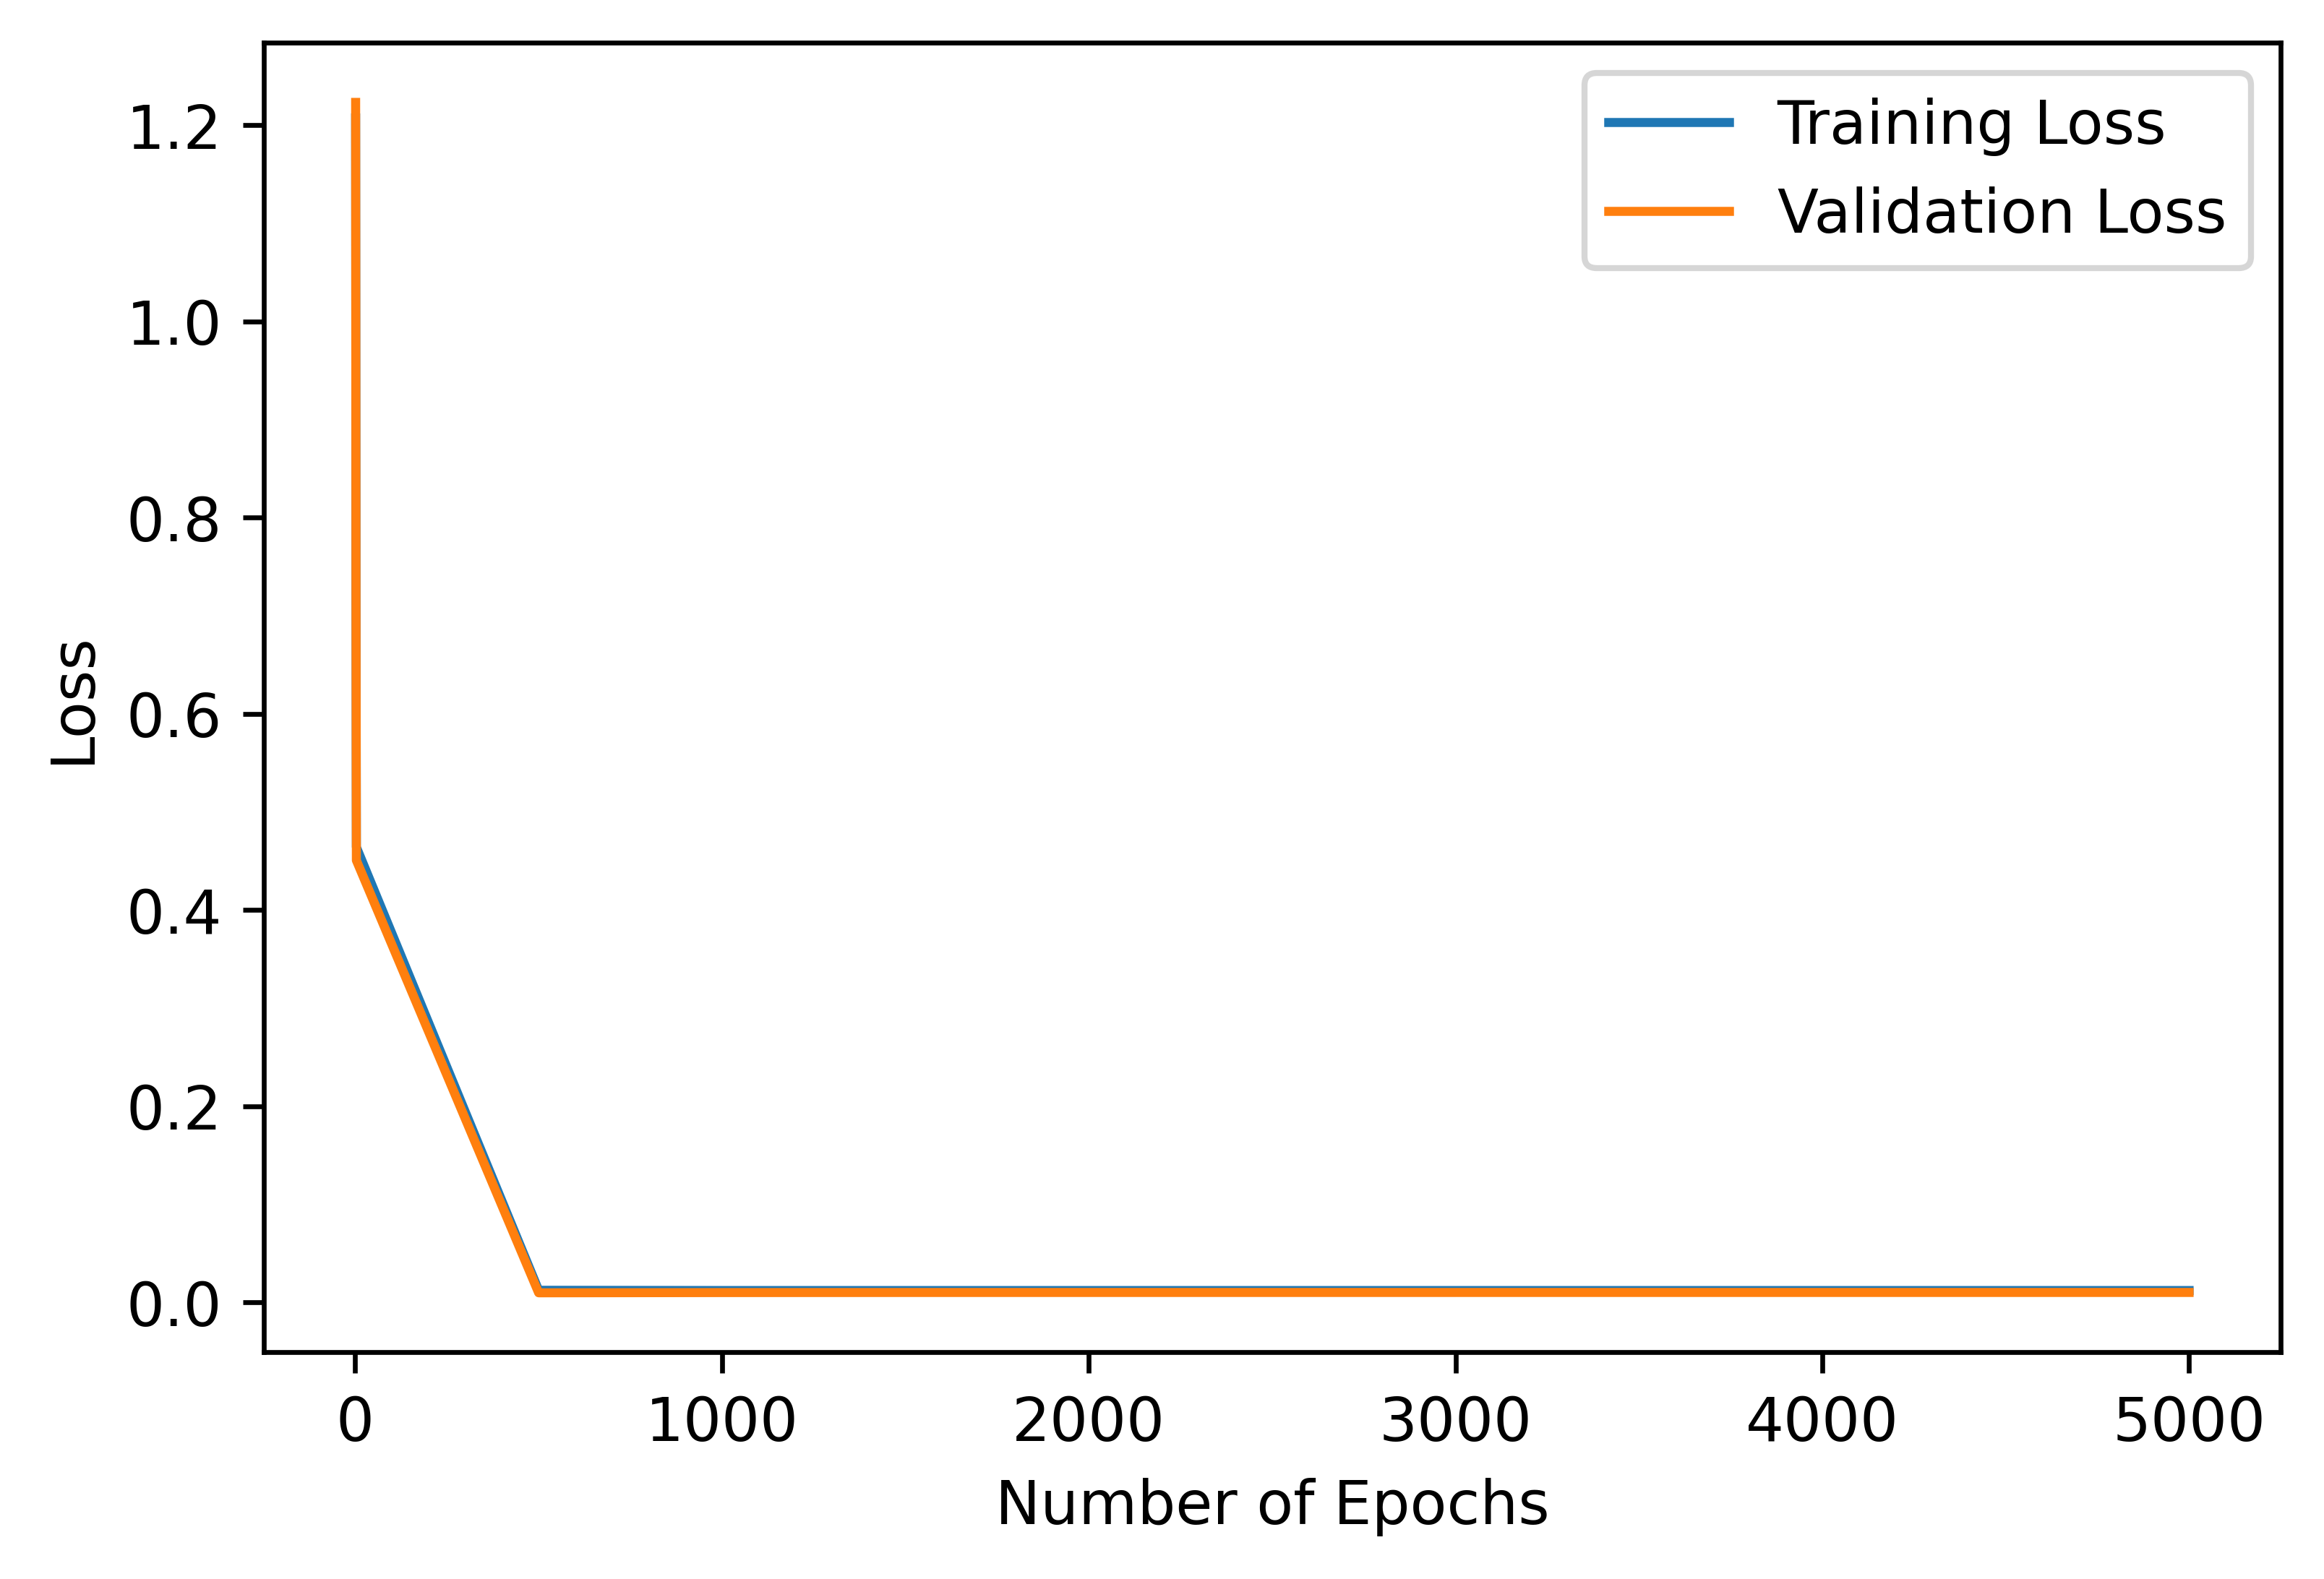

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.plot(epochs_list, loss_train_list, label="Training Loss")
plt.plot(epochs_list, loss_val_list, label="Validation Loss")
plt.legend()
plt.savefig("temp_unknown_plot.png", format="png")